In [3]:
def H(T): #test fn
    return T + 1;

H1 = H(100);
print(H1);

101


In [4]:
import numpy as np;
import matplotlib as mpl;

Freeze-out: particles will stay in thermal equilibrium with the universe as long as the reactions keeping them in chemical equilibrium are proceeding at a rate higher than the expansion of the universe. If the expansion rate is faster than the reaction rate, the partices can no longer stay in equilibrium with the universe; they are 'frozen out'.

Hubble constant formula as a fn of freeze-out temperature:
H(Tfo) = Gamma(Tfo) = v(Tfo)*n(Tfo)*sigma(Tfo)

$Y = n/S$

$n \propto a^-3$

$S \propto a^-3$

We want to plot Y.

$\Omega = \frac{m n_{DM}}{\rho_c}$

### $T_{fo} \propto \frac{1}{M_{Pl} \sigma c}$

## TODO:
Write functions to calculate the Hubble constant (DONE) and g_{*S} as a function of temperature.
[Plot H] for cold dark matter (T_fo << m).

#### optional:
Use the equipartition theorem to find the velocity of cold DM (currently approximated as c)

## done:
Write functions to calculate the equilibrium number density of particles as a function of temperature (for the relativistic and non-relativistic cases).

Plot the present-day abundance (Omega) of hot dark matter (where T_fo >> m) for different masses and cross sections. How does it scale with these variables?

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import math

c = 299792458;
v_hot = c;
v_cold = c;


#calculate the Hubble parameter at temperature T_fo.
#m = dark matter particle mass
#def H_cold(T,m,sigma):
#    return n_cold(T,m)*sigma*v_cold;

#def H_hot(T,m,sigma):
#    return n_hot(T,m)*sigma*v_hot;

#calculate number density of DM particles of mass m at temp T (cold)
#def n_cold(T,m):
#    return T**(3/2)*np.exp(-m/T);

#calculate number density of DM particles at temp T (hot)
#def n_hot(T,*m):
#    return T**3;

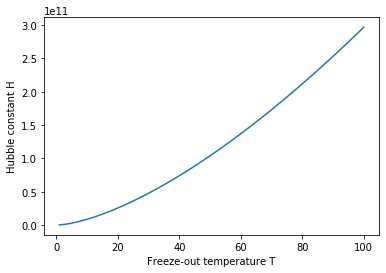

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import math

#plot Hubble constant at various temperatures
T_vect = np.linspace(1,100);
H_vect = [];
m = 1;
sigma = 1;
for T in T_vect:
    H_vect.append(H_cold(T,m,sigma));
plt.plot(T_vect,H_vect);
plt.xlabel("Freeze-out temperature T");
plt.ylabel("Hubble constant H");
plt.show();

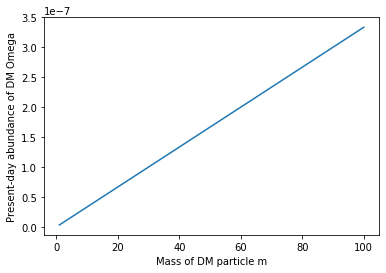

In [91]:
#calculate present-day abundance of DM as a function of m

M_pl = 1;
critical_density = 1;
T_fo = 1;
m_vect = np.linspace(1,100);
sigma = 1;

#rough approximation
def H_hot(T):
    return (T**2)/M_pl

def n_hot(T,sigma):
    return H_hot(T)/(c*sigma);

def DM_density(T,m,sigma):
    return m*n_hot(T,sigma);

def Omega(T,m,sigma):
    return DM_density(T,m,sigma)/critical_density;

Omega_vect = [];
for m in m_vect:
    Omega_vect.append(Omega(T_fo,m,sigma));
    
plt.plot(m_vect,Omega_vect);
plt.xlabel("Mass of DM particle m");
plt.ylabel("Present-day abundance of DM Omega")
plt.show();

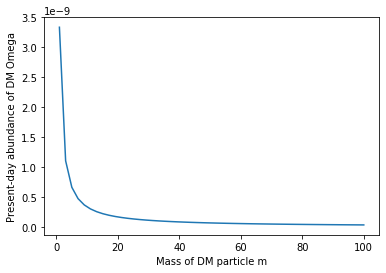

In [92]:
#calculate present-day abundance of DM as a fn of sigma

M_pl = 1;
critical_density = 1;
T_fo = 1;
sigma_vect = np.linspace(1,100);
m = 1;

#rough approximation
def H_hot(T):
    return (T**2)/M_pl

def n_hot(T,sigma):
    return H_hot(T)/(c*sigma);

def DM_density(T,m,sigma):
    return m*n_hot(T,sigma);

def Omega(T,m,sigma):
    return DM_density(T,m,sigma)/critical_density;

Omega_vect = [];
for sigma in sigma_vect:
    Omega_vect.append(Omega(T_fo,m,sigma));
    
plt.plot(sigma_vect,Omega_vect);
plt.xlabel("Mass of DM particle m");
plt.ylabel("Present-day abundance of DM Omega")
plt.show();